In [3]:

import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# PreProcess

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
Y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000

In [9]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES, output_sequence_length= 1800,
                               output_mode = 'int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)


In [15]:
batchX , batchY = dataset.as_numpy_iterator().next()

In [48]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Creating Seq Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [18]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [19]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=5, validation_data=val)


Epoch 1/5
6981/6981 [==============================] - 833s 118ms/step - loss: 0.0626 - val_loss: 0.0470
Epoch 2/5
6981/6981 [==============================] - 728s 104ms/step - loss: 0.0456 - val_loss: 0.0425
Epoch 3/5
6981/6981 [==============================] - 716s 103ms/step - loss: 0.0406 - val_loss: 0.0343
Epoch 4/5
6981/6981 [==============================] - 712s 102ms/step - loss: 0.0360 - val_loss: 0.0315
Epoch 5/5
6981/6981 [==============================] - 720s 103ms/step - loss: 0.0321 - val_loss: 0.0281


<Figure size 800x500 with 0 Axes>

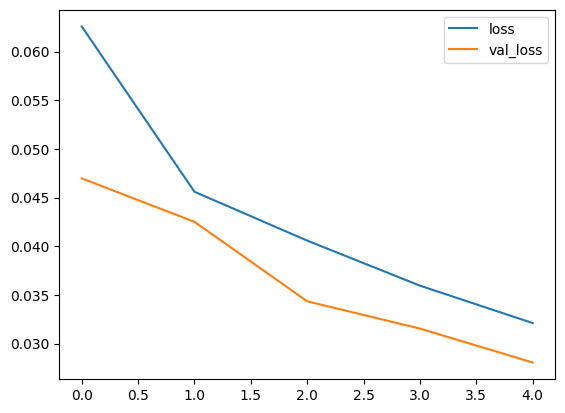

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Making Predictions

In [26]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [38]:
res = model.predict(np.array([input_text]))


1/1 [==============================] - 0s 51ms/step


In [39]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [49]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [41]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [50]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 59ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [56]:
(model.predict(batch_y) > 0.5).astype(int)

1/1 [==============================] - 0s 19ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Evaluation

In [52]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [53]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [55]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8695388436317444, Recall:0.8283237218856812, Accuracy:0.5035105347633362


# Gradio APP

In [2]:
import tensorflow as tf
import gradio as gr

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = tf.keras.models.load_model('ToxicCommentClassifier.h5')

In [11]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [12]:
interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),outputs='text')

AttributeError: module 'gradio' has no attribute 'inputs'

In [9]:
interface.launch(share=True)

NameError: name 'interface' is not defined